In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import seaborn as sns
from typing import Literal

# Dois picos idênticos

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
ws[0] = ws[1]
t2s[0] = t2s[1]
M_0s[0] = M_0s[1]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

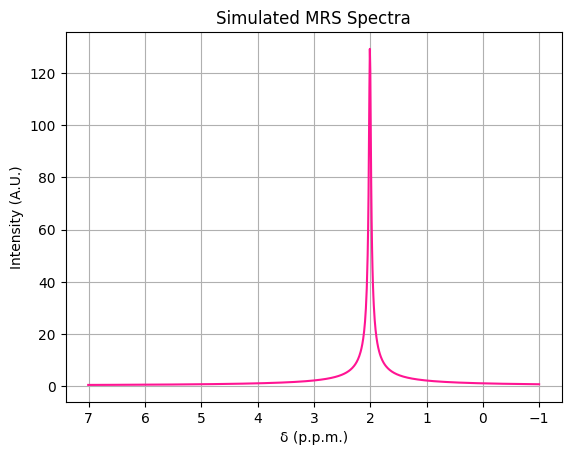

In [4]:
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [5]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [6]:
def rescale(arr : np.ndarray, min : float, max : float):
    return (arr - arr.min()) * (max - min) / (arr.max() - arr.min()) + min

In [7]:
size = 20
offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
print(offsets)


[1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06
 1.e-07 1.e-08 1.e-09 1.e-10 1.e-11 1.e-12 1.e-13 1.e-14 1.e-15 1.e-16]


In [8]:
n_avgs = 10
L_ = int(L*2048)
shape = (offsets.size, n_avgs, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [9]:
rerun = False
filename_end = ""
folder_name = "files/"
subfolder_name = "two_peaks/"

In [10]:
if rerun == True:
    for i in range(offsets.size):
        ws[1] = ws[0] + offsets[i]
        pop = pymri.population(ws, t2s, M_0s, spins_phi)

        sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)

        for j in range(n_avgs):
            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
            
            print(f"offset {offsets[i]} avg {j}")

In [11]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)

In [12]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")

In [13]:
avg_s0 = np.average(s0s_, axis=1)
std_s0 = np.std(s0s_, axis=1)

avg_phi = np.average(phis_, axis=1)
std_phi = np.std(phis_, axis=1)

avg_omega = np.average(omegas_, axis=1)
std_omega = np.std(omegas_, axis=1)

avg_t2 = np.average(t2s_, axis=1)
std_t2 = np.std(t2s_, axis=1)

In [14]:
print(avg_omega.shape)
print(avg_s0.shape)

(20, 819)
(20, 819)


In [15]:
args = np.argsort(avg_s0, axis=1)
# print(args.shape)

i = 0


identified_s0 = np.sort(avg_s0[i, args[i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(avg_omega[i, args[i, :]][L_ - 2: L_])
identified_phi = np.sort(avg_phi[i, args[i, :]][L_ - 2: L_])
identified_t2 = np.sort(avg_t2[i, args[i, :]][L_ - 2: L_])

identified_std_s0 = np.sort(std_s0[i, args[i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_std_omega = np.sort(std_omega[i, args[i, :]][L_ - 2: L_])
identified_std_phi = np.sort(std_phi[i, args[i, :]][L_ - 2: L_])
identified_std_t2 = np.sort(std_t2[i, args[i, :]][L_ - 2: L_])

print("Offset")
print(offsets[i]) 
print("Original")
print(np.sort(np.array([ws[0], ws[0] + offsets[i]])))
print("Identificado \t\t\t Desvio Padrão")
print(identified_omega, "\t",identified_std_omega)
print("Erro")
print(np.sort(np.array([ws[0], ws[0] + offsets[i]])) - identified_omega)

Offset
1000.0
Original
[2411.71251655 3411.71251655]
Identificado 			 Desvio Padrão
[2411.71251655 3411.71251655] 	 [4.54747351e-13 4.54747351e-13]
Erro
[ 1.36424205e-12 -2.27373675e-12]


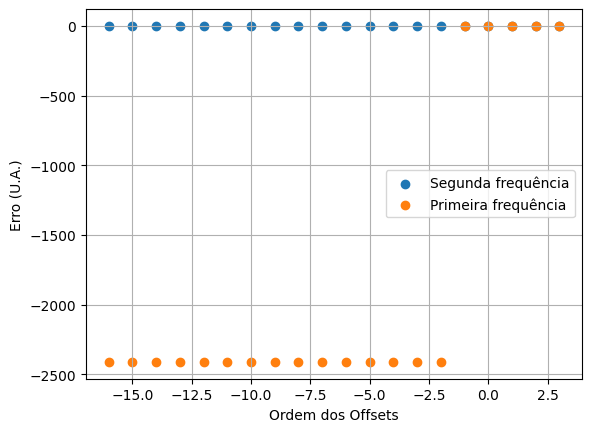

In [16]:
first_error, second_error = np.zeros_like(offsets), np.zeros_like(offsets)
for k in range(offsets.size):
    compare_arr = np.sort(avg_omega[k, args[k, :]][L_ - 2: L_])
    first_error[k] = compare_arr[0] - ws[0]
    second_error[k] = compare_arr[1] - (ws[0] + offsets[k])

# plt.figure(figsize=(10, 7))
plt.scatter(np.log10(offsets), second_error, label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error, label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.legend()
plt.grid()

Acima, é possível perceber que o limite de identificação de picos esbarra em 0.1Hz. Uma tese para esse limite é que a resolução da simulação é uma barreira: O sinal tem 2048 pontos, coletados no intervalo de tempo de 1s, o que da uma resolução de [-2048/2, 2048/2] Hz. Essas características configuram ao sinal resolução de 1Hz por ponto, perto da barreira a qual a identificação começa a falhar. Aparentemente o limite do algoritmo é a resolução do sinal.

REVISADO

Aparentemente o limite acima mencionado existe, mas com um porém: o formato dos picos importa. Outros testes foram rodados com picos de tamanhos diferentes e parece que foi possível identificar picos individuais além desse limite. Mais abaixo foram feitos testes para investigar isso.

In [17]:
identified_pop = pymri.population(identified_omega, identified_t2, identified_s0, identified_phi)

identified_sig, t = pymri.population_transverse_decay( t0, tn, dt, identified_pop, np.array([]) )
_, identified_sig_fft = pymri.fourier_spectrum(identified_sig, dt, B0)

([], [])

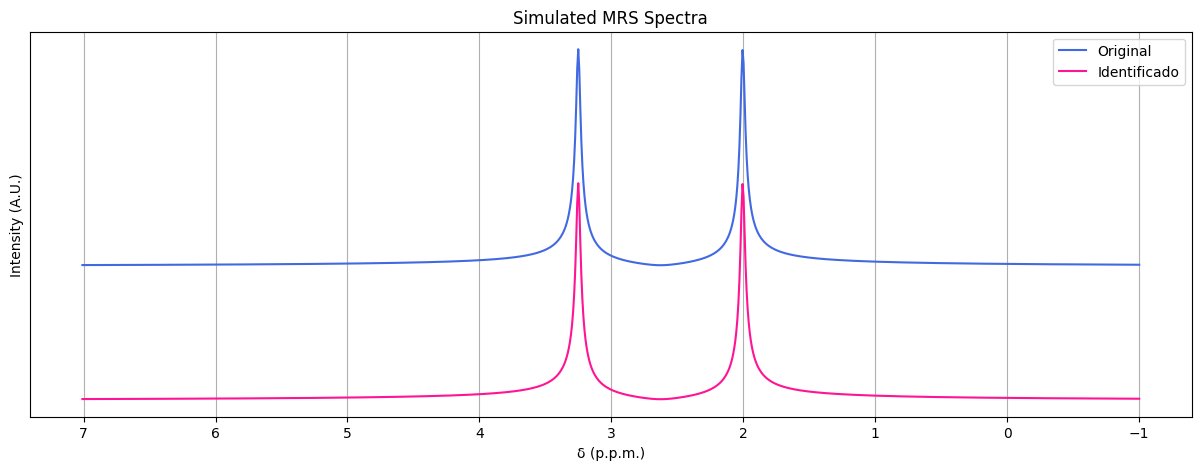

In [18]:
ws[1] = ws[0] + offsets[i]
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum(sig, dt, B0)

y_offset = 20.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, sig_fft, 1.0, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, identified_sig_fft, 1.0, y_offset=y_offset, label="Identificado")
plt.legend()
plt.yticks([])

# Dois picos diferentes

## $S_0$

In [11]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
spins_phi = np.zeros_like(M_0s)

M_0s[0] = M_0s[1]
t2s[0] = t2s[1]

print("Freqs (rad/s),\t\t\t T_2s (s),\t\t M_0s (U.A.),\t\t phis (rad)")
print(ws, "\t", t2s, "\t", M_0s, "\t", spins_phi)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),			 T_2s (s),		 M_0s (U.A.),		 phis (rad)
[2355.21183064 2411.71251655] 	 [0.0735 0.0735] 	 [0.4289 0.4289] 	 [0. 0.]
All frequencies are captured by the sampling rate.


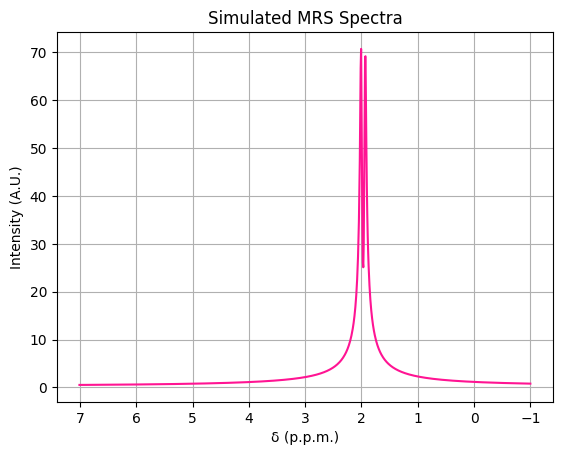

In [12]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [13]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [14]:
size = 20
offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
s0_offsets = np.arange(0.05, 1.05, 0.05)
print(s0_offsets)


[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


In [15]:
L_ = int(L*2048)
shape = (offsets.size, s0_offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [16]:
rerun = False
filename_end = "_peaks_change"
folder_name = "files/"
subfolder_name = "two_peaks/"

In [59]:
if rerun == True:
    for i in range(offsets.size):
        for j in range(s0_offsets.size):
            ws[1] = ws[0] + offsets[i]
            M_0s[1] = s0_offsets[j]*M_0s[0]
            pop = pymri.population(ws, t2s, M_0s, spins_phi)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)

            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
            
            print(f"offset {offsets[i]} s0 {s0_offsets[j]}")

In [ ]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)
    np.save(folder_name + subfolder_name + "s0_offsets" + filename_end, s0_offsets)

In [26]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
    # s0_offsets = np.load(folder_name + subfolder_name + "s0_offsets" + filename_end + ".npy")

In [27]:
print(s0s_.shape)

(20, 20, 819)


In [37]:
# shape = (offsets.size, s0_offsets.size, L_)

i = 5
s0_i = 10


args = np.argsort(s0s_, axis=2)
print(args.shape)


identified_s0 = np.sort(s0s_[i, s0_i, args[i, s0_i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(omegas_[i, s0_i, args[i, s0_i, :]][L_ - 2: L_])
identified_phi = np.sort(phis_[i, s0_i, args[i, s0_i, :]][L_ - 2: L_])
identified_t2 = np.sort(t2s_[i, s0_i, args[i, s0_i, :]][L_ - 2: L_])

print(f"Offset de frequência {offsets[i]} | Offset de S0 {s0_offsets[s0_i]}")
print(offsets[i]) 
print("Original")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])))
print("Identificado \t\t\t Desvio Padrão")
print(identified_omega)
print("Erro")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])) - identified_omega)

(20, 20, 819)
Offset de frequência 0.01 | Offset de S0 0.55
0.01
Original
[2411.71251655 2411.72251655]
Identificado 			 Desvio Padrão
[   0.         2411.71606494]
Erro
[2.41171252e+03 6.45161317e-03]


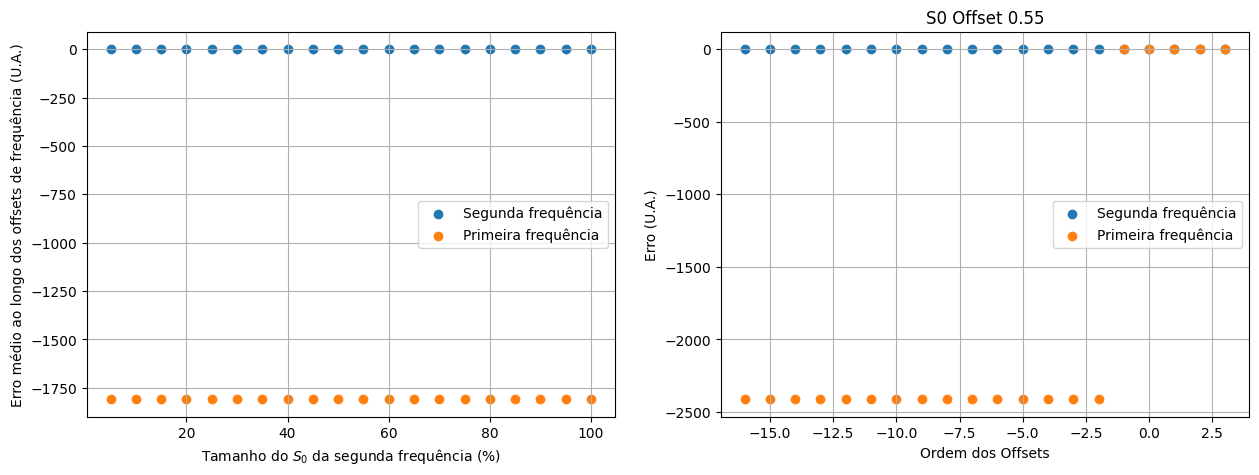

In [38]:
first_error, second_error = np.zeros((offsets.size, s0_offsets.size)), np.zeros((offsets.size, s0_offsets.size))
for j in range(s0_offsets.size):
    for k in range(offsets.size):
        compare_arr = np.sort(omegas_[k, j, args[k, j, :]][L_ - 2: L_])
        first_error[k, j] = compare_arr[0] - ws[1]
        second_error[k, j] = compare_arr[1] - (ws[1] + offsets[k])

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(s0_offsets*100, np.average(second_error, axis = 0), label = f"Segunda frequência")
plt.scatter(s0_offsets*100, np.average(first_error, axis = 0), label = "Primeira frequência")
plt.xlabel(r"Tamanho do $S_0$ da segunda frequência (%)")
plt.ylabel("Erro médio ao longo dos offsets de frequência (U.A.)")
# plt.ylim(-1810, -1808)
plt.legend()
plt.grid()

plt.subplot(122)
plt.scatter(np.log10(offsets), second_error[:, s0_i], label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error[:, s0_i], label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.title(f"S0 Offset {round(s0_offsets[s0_i], 4)}")
# plt.ylim(-10*1e-12, 10*1e-12)
plt.legend()
plt.grid()


In [28]:
identified_pop = pymri.population(identified_omega, identified_t2, identified_s0, identified_phi)

identified_sig, t = pymri.population_transverse_decay( t0, tn, dt, identified_pop, np.array([]) )
_, identified_sig_fft = pymri.fourier_spectrum(identified_sig, dt, B0)

([], [])

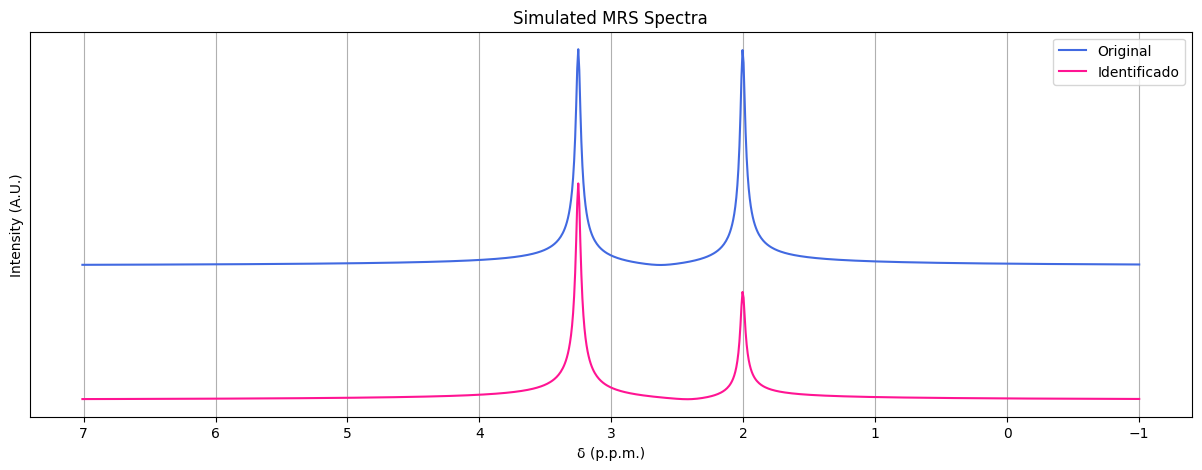

In [29]:
ws[1] = ws[0] + offsets[i]
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum(sig, dt, B0)

y_offset = 20.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, sig_fft, 1.0, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, identified_sig_fft, 1.0, y_offset=y_offset, label="Identificado")
plt.legend()
plt.yticks([])

O tamanho do pico não importa. Talvez o T2 importe.

### Conclusão preliminar

A ideia de que o limite de detecção se ancora na resolução do sinal parece falsa. Nesse sinal, o limte da resolução é de $1 / Hz$, ou $\approx 6.28 / rad/s$, enquanto o método consegue detectar dois picos distintos apenas por $0.1 / rad/s$, ou $\approx 0.016 / Hz$. Sugere-se investigar melhor, talvez aumentando os parâmetros da própria simulação, como o tempo de simulação (aumentar o tn).

Outro fator importante de se comentar é que esse limite parece existir para dois picos de parâmetros idênticos diferindo apenas por um offset de frequência, porém foi verificado que para dois picos de parâmetros diferentes esse limite parece mudar significativamente.

## $T_2$

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
spins_phi = np.zeros_like(M_0s)

print("Freqs (rad/s),\t\t\t T_2s (s),\t\t M_0s (U.A.)")
print(ws, "\t", t2s, "\t", M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),			 T_2s (s),		 M_0s (U.A.)
[2355.21183064 2411.71251655] 	 [0.0199 0.0735] 	 [0.2917 0.4289]
All frequencies are captured by the sampling rate.


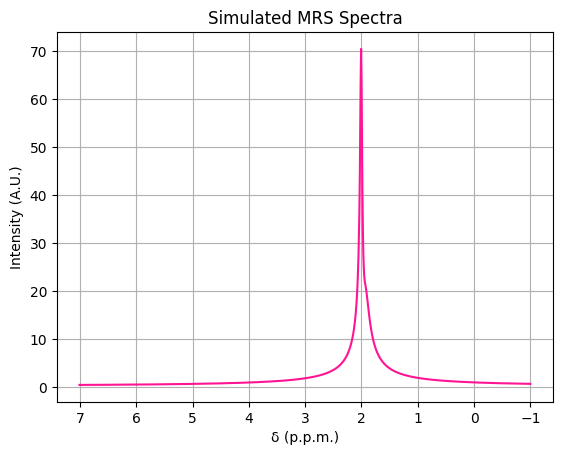

In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [4]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [5]:
size = 20
offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
t2_offsets = np.arange(0.9955, 1.0005, 0.0005)
print(t2_offsets)

[0.9955 0.996  0.9965 0.997  0.9975 0.998  0.9985 0.999  0.9995 1.    ]


In [6]:
L_ = int(L*2048)
shape = (offsets.size, t2_offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [ ]:
rerun = False
# filename_end = "_different_freqs"
ends_t2 = ["_t2_offsets_1", "_t2_offsets_2", "_t2_offsets_3", "_t2_offsets_4"]
filename_end = ends_t2[3]
folder_name = "files/"
subfolder_name = "two_peaks/"

In [ ]:
if rerun == True:
    for i in range(offsets.size):
        for j in range(t2_offsets.size):
            ws[0] = ws[1] + offsets[i]
            t2s[0] = t2s[1]*t2_offsets[j]
            M_0s[0] = M_0s[1]
            pop = pymri.population(ws, t2s, M_0s, spins_phi)
            
            print(f"offset {offsets[i]} t2 offset {t2_offsets[j]}")
            print(ws, t2s, M_0s, spins_phi)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
            

In [51]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)
    np.save(folder_name + subfolder_name + "offsets" + filename_end, t2_offsets)

In [52]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
    t2_offsets = np.load(folder_name + subfolder_name + "offsets" + filename_end + ".npy")

In [53]:
print(t2_offsets)

[0.9955 0.996  0.9965 0.997  0.9975 0.998  0.9985 0.999  0.9995 1.    ]


In [13]:
i = 0
t2_i = 9

args = np.argsort(s0s_, axis=2)

identified_s0 = np.sort(s0s_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(omegas_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_])
identified_phi = np.sort(phis_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_])
identified_t2 = np.sort(t2s_[i, t2_i, args[i, t2_i, :]][L_ - 2: L_])

print("Offset  \t T2 Offset")
print(offsets[i], "\t\t", t2_offsets[t2_i]) 
print("Original")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])))
print("Identificado")
print(identified_omega)
print("Erro")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])) - identified_omega)

Offset  	 T2 Offset
1000.0 		 1.0
Original
[2411.71251655 3411.71251655]
Identificado
[2411.71251655 3411.71251655]
Erro
[ 1.8189894e-12 -1.8189894e-12]


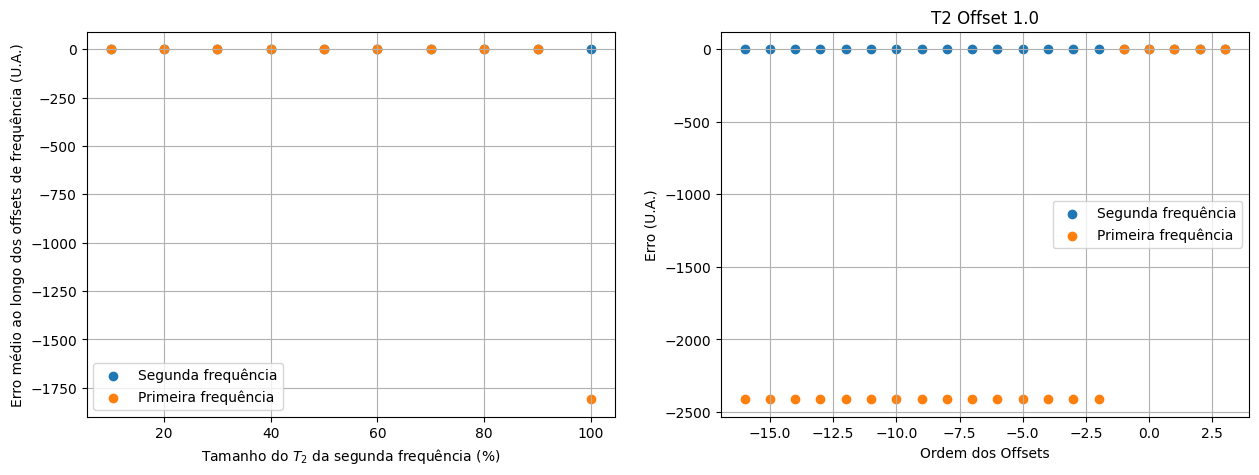

In [14]:
first_error, second_error = np.zeros((offsets.size, t2_offsets.size)), np.zeros((offsets.size, t2_offsets.size))
for j in range(t2_offsets.size):
    for k in range(offsets.size):
        compare_arr = np.sort(omegas_[k, j, args[k, j, :]][L_ - 2: L_])
        first_error[k, j] = compare_arr[0] - ws[1]
        second_error[k, j] = compare_arr[1] - (ws[1] + offsets[k])

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(t2_offsets*100, np.average(second_error, axis = 0), label = f"Segunda frequência")
plt.scatter(t2_offsets*100, np.average(first_error, axis = 0), label = "Primeira frequência")
plt.xlabel(r"Tamanho do $T_2$ da segunda frequência (%)")
plt.ylabel("Erro médio ao longo dos offsets de frequência (U.A.)")
# plt.ylim(-1810, -1808)
plt.legend()
plt.grid()

plt.subplot(122)
plt.scatter(np.log10(offsets), second_error[:, t2_i], label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error[:, t2_i], label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.title(f"T2 Offset {round(t2_offsets[t2_i], 4)}")
# plt.ylim(-10*1e-12, 10*1e-12)
plt.legend()
plt.grid()


([], [])

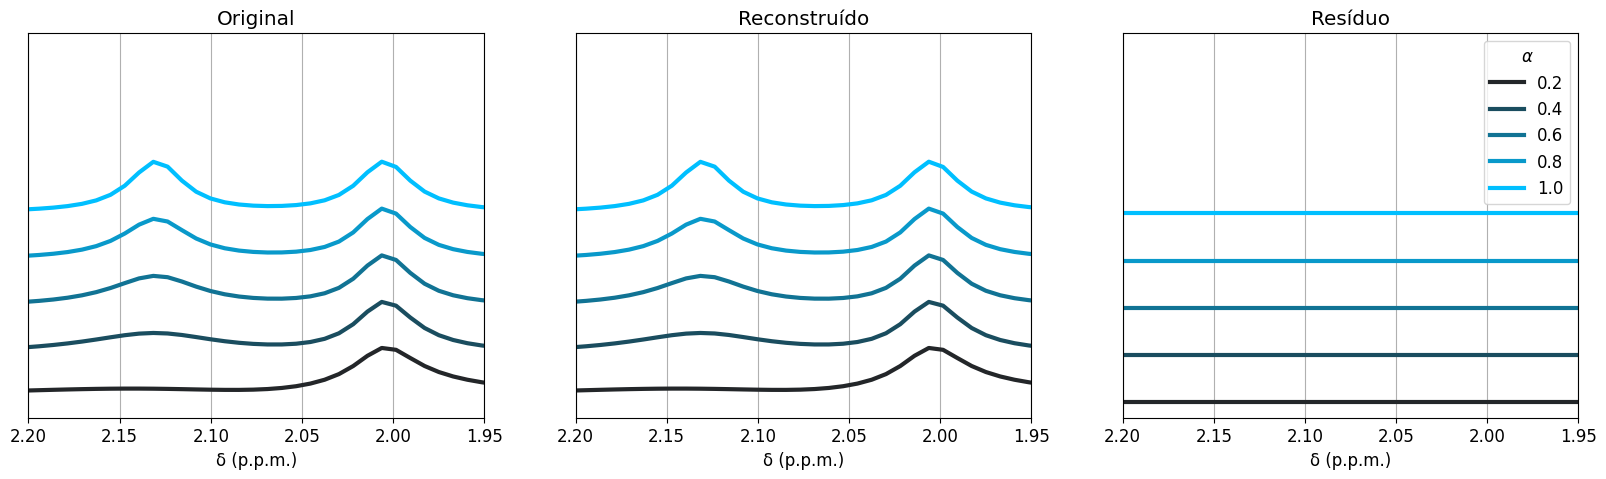

In [15]:
n = t2_offsets.size//2
offset = 1

#rebuilding the signal
sigs_fft = np.zeros((n, 2048), np.complex128)
sigs_fft_rebuilt = np.zeros((n, 2048), np.complex128)

for j in range(n):
    t2_offset = 2*j + 1
    ws[0] = ws[1] + offsets[offset]
    t2s[0] = t2s[1]*t2_offsets[t2_offset]
    M_0s[0] = M_0s[1]
    pop = pymri.population(ws, t2s, M_0s, spins_phi)
    sig, t = pymri.population_transverse_decay(t0, tn, dt, pop)
    freqs, sigs_fft[j, :] = pymri.fourier_spectrum(sig, dt, B0)

    omegas__ = omegas_[offset, t2_offset, :][t2s_[offset, t2_offset, :] != 0.0]
    t2s__ = t2s_[offset, t2_offset, :][t2s_[offset, t2_offset, :] != 0.0]
    s0s__ = s0s_[offset, t2_offset, :][t2s_[offset, t2_offset, :] != 0.0]
    phis__ = phis_[offset, t2_offset, :][t2s_[offset, t2_offset, :] != 0.0]

    pop2 = pymri.population(omegas__, t2s__, s0s__, phis__)
    sig2, t = pymri.population_transverse_decay(t0, tn, dt, pop2)
    freqs, sigs_fft_rebuilt[j, :] = pymri.fourier_spectrum(sig2, dt, B0)

# Building the y_offsets array
y_offset = 60
xlim = (1.95, 2.2)
ylim = (-20, 470)
freqs_arr = np.full((n, freqs.size), freqs)
y_offsets = np.ones_like(sigs_fft)
alphas = np.zeros_like(freqs_arr, dtype = "float")

for k in range(n):
    y_offsets[k] = k*y_offsets[k]*y_offset
    alphas[k, :] = np.full(freqs.size, t2_offsets[2*k + 1])


#plot
palette_1 = sns.dark_palette("#1E90FF", n_colors= n, reverse = False)
palette_2 = sns.dark_palette("#00BFFF", n_colors= n, reverse = False)
palette_3 = sns.dark_palette("#9400D3", n_colors= n, reverse = True)

linewidth = 3.0


plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.ylim(ylim)
plt.xlim(xlim)
pymri.sns_plot_chem_shifts(freqs_arr, sigs_fft + y_offsets, 
                           title = "Original", ylabel=None, 
                           palette = palette_2, hue = alphas, hue_label=r"$\alpha$", linewidth=linewidth)
plt.yticks([])
plt.legend([],[], frameon=False)

plt.subplot(132)
plt.ylim(ylim)
plt.xlim(xlim)
pymri.sns_plot_chem_shifts(freqs_arr, sigs_fft_rebuilt + y_offsets, 
                           title = "Reconstruído", ylabel=None, 
                           palette = palette_2, hue = alphas, hue_label=r"$\alpha$", linewidth=linewidth)
plt.yticks([])
plt.legend([],[], frameon=False)

plt.subplot(133)
plt.ylim(ylim)
plt.xlim(xlim)
pymri.sns_plot_chem_shifts(freqs_arr, sigs_fft - sigs_fft_rebuilt + y_offsets, 
                           title = "Resíduo", ylabel=None, 
                           palette = palette_2, hue = alphas, hue_label=r"$\alpha$", linewidth=linewidth)
plt.yticks([])

In [16]:
print(offsets[1]/pymri.GAMMA*B0)

7.0459785511909345


Acima considerando $\alpha = \frac{T_2'}{T_2}$ 

#### Offset de $f$


In [17]:
f_offsets_pick = np.array([1, 2, 4, 10, 19])
t2_offsets_pick = np.array([1, 5, 9])

print(offsets[f_offsets_pick])

[1.e+02 1.e+01 1.e-01 1.e-07 1.e-16]


In [18]:
m = f_offsets_pick.size
t2_offset_i = t2_offsets_pick[2]

print(f"t2 offset : {t2_offsets[t2_offset_i]}, f offsets : {offsets[f_offsets_pick]}")

#rebuilding the signal
sigs_fft_f = np.zeros((m, 2048), np.complex128)
sigs_fft_f_rebuilt = np.zeros((m, 2048), np.complex128)

for j in range(m):
    offset = f_offsets_pick[j]
    print(offsets[offset])
    ws[0] = ws[1] + offsets[offset]
    t2s[0] = t2s[1]*t2_offsets[t2_offset_i]
    M_0s[0] = M_0s[1]
    pop = pymri.population(ws, t2s, M_0s, spins_phi)
    sig, t = pymri.population_transverse_decay(t0, tn, dt, pop)
    freqs, sigs_fft_f[j, :] = pymri.fourier_spectrum(sig, dt, B0)

    omegas__ = omegas_[offset, t2_offset_i, :][t2s_[offset, t2_offset_i, :] != 0.0]
    t2s__ = t2s_[offset, t2_offset_i, :][t2s_[offset, t2_offset_i, :] != 0.0]
    s0s__ = s0s_[offset, t2_offset_i, :][t2s_[offset, t2_offset_i, :] != 0.0]
    phis__ = phis_[offset, t2_offset_i, :][t2s_[offset, t2_offset_i, :] != 0.0]

    pop2 = pymri.population(omegas__, t2s__, s0s__, phis__)
    sig2, t = pymri.population_transverse_decay(t0, tn, dt, pop2)
    freqs, sigs_fft_f_rebuilt[j, :] = pymri.fourier_spectrum(sig2, dt, B0)
    print(np.max(np.abs(sigs_fft_f_rebuilt[j, :] - sigs_fft_f[j, :])))

# Building the y_offsets array
y_offset_2 = 90
freqs_arr_f = np.full((m, freqs.size), freqs)
y_offsets_f = np.ones_like(sigs_fft)
f_offsets = np.zeros_like(freqs_arr, dtype = "float")

for k in range(m):
    y_offsets_f[k] = k*y_offsets_f[k]*y_offset_2
    f_offsets[k, :] = np.round(np.full(freqs.size, np.log10(pymri.rad_to_hz( offsets[f_offsets_pick[k]] )/pymri.GAMMA*B0)), 1)
    # f_offsets[k, :] = np.full(freqs.size, round( pymri.chem_shift_from_f(pymri.rad_to_hz( offsets[f_offsets_pick[k]] ), B0), 5) ) #Convertendo para ppm para mostrar nas unidades certas do gráfico


t2 offset : 1.0, f offsets : [1.e+02 1.e+01 1.e-01 1.e-07 1.e-16]
100.0
1.1815345956690467e-11
10.0
4.2818144788048984e-12
0.1
1.883143525754066e-09
1e-07
3.7682235756059776e-12
1e-16
1.274464728425693e-11


([], [])

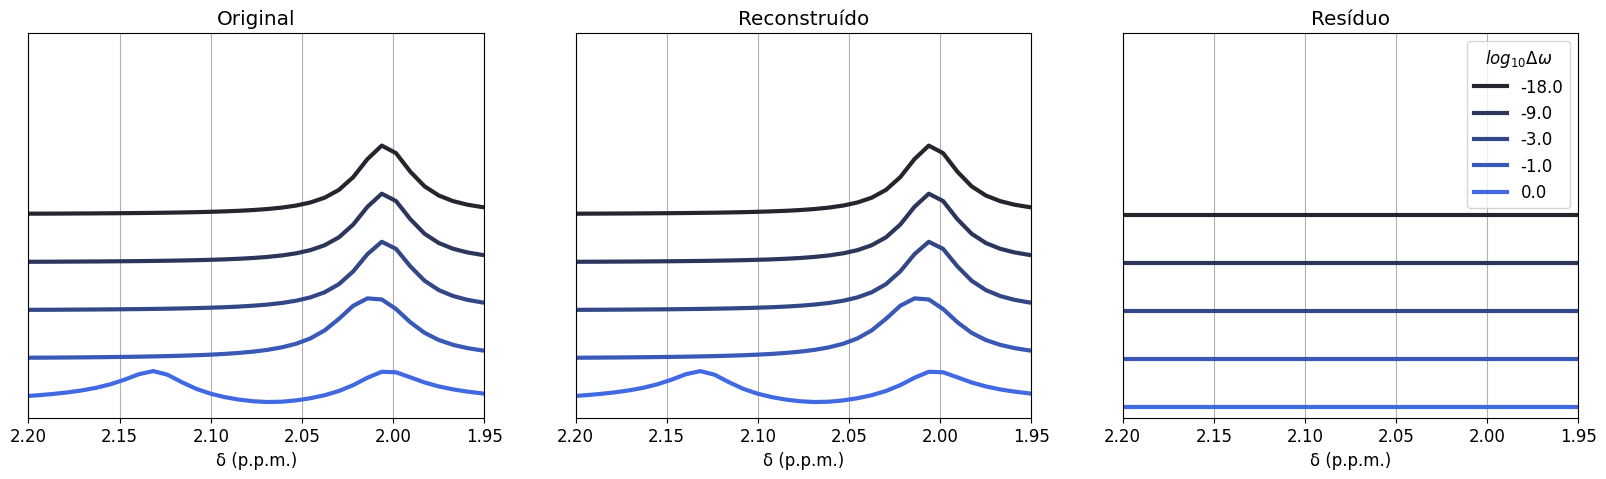

In [19]:
palette_4 = sns.dark_palette("#4169E1", n_colors= n, reverse = False)

ylim_2 = (-20, 700)

linewidth = 3.0


plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.ylim(ylim_2)
plt.xlim(xlim)
pymri.sns_plot_chem_shifts(freqs_arr, sigs_fft_f + y_offsets_f, title = "Original", 
                           ylabel=None, palette = palette_4, hue = f_offsets, 
                           hue_label=r"$log_{10} \Delta \omega$ (MHz)", linewidth=linewidth)
plt.yticks([])
plt.legend([],[], frameon=False)
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["left"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

plt.subplot(132)
plt.ylim(ylim_2)
plt.xlim(xlim)
pymri.sns_plot_chem_shifts(freqs_arr, sigs_fft_f_rebuilt + y_offsets_f, title = "Reconstruído", 
                           ylabel=None, palette = palette_4, hue = f_offsets, 
                           hue_label=r"$log_{10} \Delta \omega$ (MHz)", linewidth=linewidth)
plt.yticks([])
plt.legend([],[], frameon=False)

plt.subplot(133)
plt.ylim(ylim_2)
plt.xlim(xlim)
pymri.sns_plot_chem_shifts(freqs_arr, sigs_fft_f - sigs_fft_f_rebuilt + y_offsets_f, title = "Resíduo", 
                           ylabel=None, palette = palette_4, hue = f_offsets, 
                           hue_label=r"$log_{10} \Delta \omega$ ", linewidth=linewidth)
plt.yticks([])
# plt.legend([],[], frameon=False)

Criar um gráfico intermediário com os dois picos separados, com um pequeno offset no y pra diferenciar.

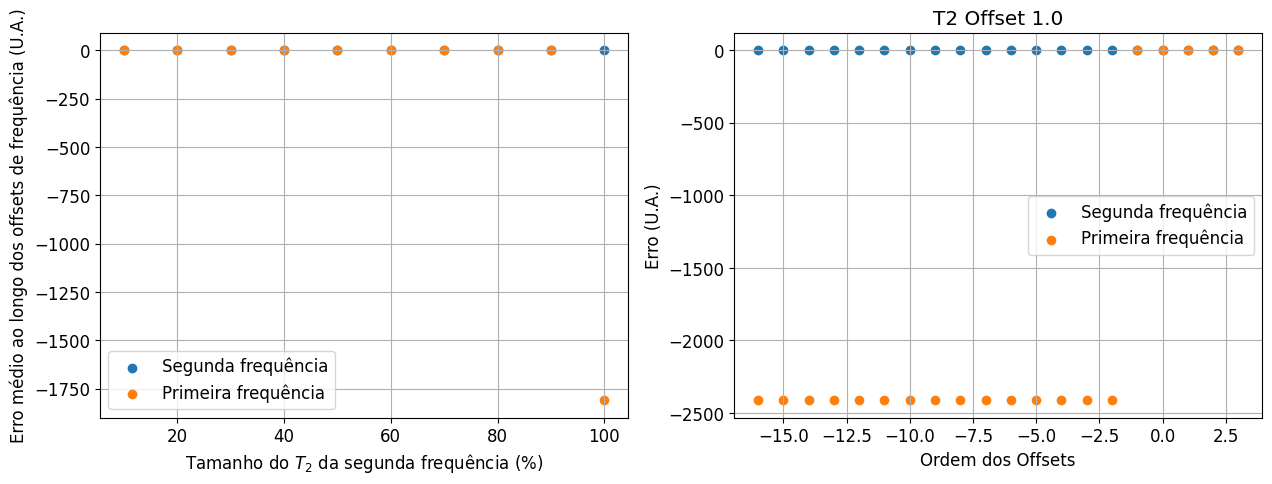

In [71]:
first_error, second_error = np.zeros((offsets.size, t2_offsets.size)), np.zeros((offsets.size, t2_offsets.size))
for j in range(t2_offsets.size):
    for k in range(offsets.size):
        compare_arr = np.sort(omegas_[k, j, args[k, j, :]][L_ - 2: L_])
        first_error[k, j] = compare_arr[0] - ws[1]
        second_error[k, j] = compare_arr[1] - (ws[1] + offsets[k])

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(t2_offsets*100, np.average(second_error, axis = 0), label = f"Segunda frequência")
plt.scatter(t2_offsets*100, np.average(first_error, axis = 0), label = "Primeira frequência")
plt.xlabel(r"Tamanho do $T_2$ da segunda frequência (%)")
plt.ylabel("Erro médio ao longo dos offsets de frequência (U.A.)")
# plt.ylim(-1810, -1808)
plt.legend()
plt.grid()

plt.subplot(122)
plt.scatter(np.log10(offsets), second_error[:, t2_i], label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error[:, t2_i], label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.title(f"T2 Offset {round(t2_offsets[t2_i], 4)}")
# plt.ylim(-10*1e-12, 10*1e-12)
plt.legend()
plt.grid()


Ideia : fazer um plot com a mesma dinâmica dos de espectro, mas com os erros pra cada t2 offset diferentes, mas dessa vez ao longo do eixo x.

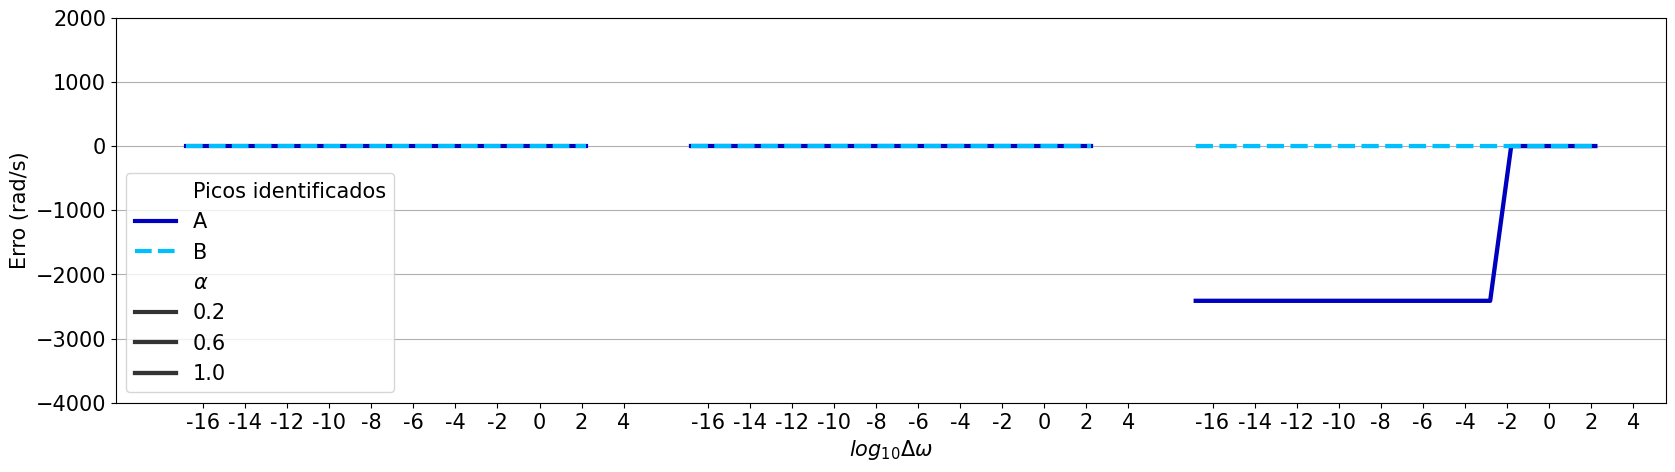

In [74]:
o = t2_offsets_pick.size
t2_offsets_arr = np.full((o, offsets.size), np.log10(offsets))
first_error_arr = first_error.T[t2_offsets_pick, :]
second_error_arr = second_error.T[t2_offsets_pick, :]

x_dist = 24.0
y_dist = -1000.0
xlim_2 = (-16, 6)
ylim_2 = (-4000, 2000)

x_dists = np.ones_like(first_error.T[t2_offsets_pick, :])
y_dists = np.ones_like(first_error.T[t2_offsets_pick, :])
f_offsets_t2 = np.ones_like(first_error.T[t2_offsets_pick, :])
t2_offsets_arr = np.ones_like(first_error.T[t2_offsets_pick, :])
markers_first = np.ones_like(first_error.T[t2_offsets_pick, :], dtype = str)
markers_secon = np.ones_like(first_error.T[t2_offsets_pick, :], dtype = str)

for k in range(o):
    x_dists[k, :] = k*x_dist*x_dists[k, :]
    f_offsets_t2[k, :] = np.round( np.full(first_error.T[k, :].size, np.log10(pymri.rad_to_hz( offsets ))), 2)
    t2_offsets_arr[k, :] = np.full((first_error.T[k, :].size), t2_offsets[t2_offsets_pick[k]])
    markers_first[k, :] = np.full((first_error.T[k, :].size), "A")
    markers_secon[k, :] = np.full((first_error.T[k, :].size), "B")


palette_5 = sns.dark_palette("#DC143C", n_colors = t2_offsets_pick.size, reverse = True)
palette_6 = sns.dark_palette("#0000BF", n_colors = t2_offsets_pick.size, reverse = True)
palette_7 = sns.color_palette(["#0000BF", "#00BFFF"])
x_label = r'$log_{10} \Delta \omega$'
y_label = "Erro (rad/s)"
style_label = r'$\alpha$'
hue_label = "Picos identificados"

df_first = {x_label : f_offsets_t2.flatten(), y_label : (first_error_arr  + y_dists).flatten(), hue_label : t2_offsets_arr.flatten()}
df_secon = {x_label : f_offsets_t2.flatten(), y_label : (second_error_arr + y_dists).flatten(), hue_label : t2_offsets_arr.flatten()}

df = {x_label : np.concatenate( ((f_offsets_t2 + x_dists).flatten(), (f_offsets_t2 + x_dists).flatten()) ), 
      y_label : np.concatenate( (first_error_arr.flatten(), second_error_arr.flatten()) ), 
      style_label : np.concatenate((t2_offsets_arr.flatten(), t2_offsets_arr.flatten())),
      hue_label : np.concatenate((markers_first.flatten(), markers_secon.flatten()))}


plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(20, 5))
sns.lineplot(x = x_label, y = y_label, data=df, hue=hue_label, 
             palette=palette_7, style=hue_label, markers=False, 
             dashes = True, size = style_label, linewidth=linewidth, markersize = 10, sizes=(3.0, 3.1))
plt.xticks(list(np.arange(xlim_2[0], xlim_2[1], 2)) + 
           list(np.arange(xlim_2[0], xlim_2[1], 2) + x_dist) + 
           list(np.arange(xlim_2[0], xlim_2[1], 2) + 2*x_dist), 
           list(np.arange(xlim_2[0], xlim_2[1], 2)) + 
           list(np.arange(xlim_2[0], xlim_2[1], 2)) +
           list(np.arange(xlim_2[0], xlim_2[1], 2)))
plt.ylim(-4000, 2000)
plt.grid(axis = 'y')


# plt.subplot(122)
# sns.lineplot(x = x_label, y = y_label, data=df_secon, hue=hue_label, palette=palette_5)
# # plt.yticks([], [])
# plt.ylim(-5000, 2000)
# plt.grid(axis = 'y')

### Conclusão Preliminar

O $T_2$ influencia diretamente na capacidade do algoritmo de identificar picos sobrepostos. Essa identificação parece ser efetiva até por volta de $99.85\%$ de similaridade de $T_2$. Após esse limite, o algoritmo passa a identificar os dois picos como um pico só.

Fazer um gráfico com todos os offsets de T2, mostrando os picos. Do lado, mostrar os mesmos picos reconstruídos pelo MPM, e do lado, mostrar o resíduo. Depois, pegar apenas alguns offsets de T2 (0.8, 1.0), e mostrar agora os offsets de frequência diminuindo.

## $\phi$

In [54]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
spins_phi = np.zeros_like(M_0s)

M_0s[0] = M_0s[1]
t2s[0] = t2s[1]

print("Freqs (rad/s),\t\t\t T_2s (s),\t\t M_0s (U.A.),\t\t phis (rad)")
print(ws, "\t", t2s, "\t", M_0s, "\t", spins_phi)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),			 T_2s (s),		 M_0s (U.A.),		 phis (rad)
[2355.21183064 2411.71251655] 	 [0.0735 0.0735] 	 [0.4289 0.4289] 	 [0. 0.]
All frequencies are captured by the sampling rate.


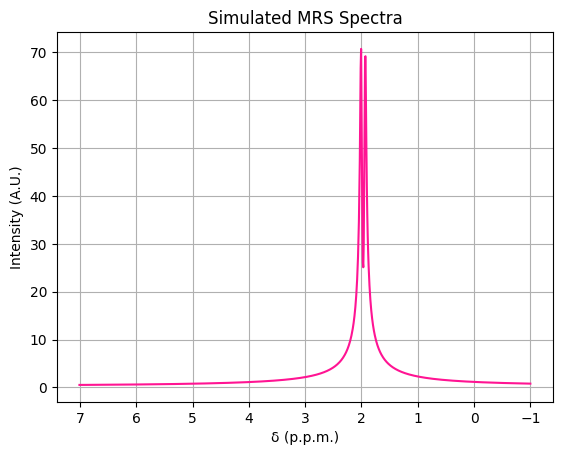

In [55]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [56]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [57]:
size = 20
offsets = 10**(-(np.linspace(-3, size - 3 - 1, size)))
step = 0.001*np.pi
phi_offsets = np.arange(0.991*np.pi, np.pi + step, step)
print(phi_offsets)

[3.11331832 3.11645991 3.11960151 3.1227431  3.12588469 3.12902628
 3.13216788 3.13530947 3.13845106 3.14159265]


In [58]:
L_ = int(L*2048)
shape = (offsets.size, phi_offsets.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [59]:
rerun = False
ends_phi = ["_phi_offsets_1", "_phi_offsets_2", "_phi_offsets_3"]
filename_end = ends_phi[0]
folder_name = "files/"
subfolder_name = "two_peaks/"

In [221]:
if rerun == True:
    for i in range(offsets.size):
        for j in range(phi_offsets.size):
            ws[0] = ws[1] + offsets[i]
            spins_phi[0] = spins_phi[1] + phi_offsets[j]
        
            pop = pymri.population(ws, t2s, M_0s, spins_phi)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[i, j, :], phis_[i, j, :], omegas_[i, j, :], t2s_[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[i, j, :] = 1/t2s_[i, j, :]
            
            print(f"offset {offsets[i]} phi offset {phi_offsets[j]}")

In [222]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)
    np.save(folder_name + subfolder_name + "phi_offsets" + filename_end, phi_offsets)

In [60]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")
    phi_offsets = np.load(folder_name + subfolder_name + "phi_offsets" + filename_end + ".npy")

In [61]:
print(phi_offsets)

[0.         0.31415927 0.62831853 0.9424778  1.25663706 1.57079633
 1.88495559 2.19911486 2.51327412 2.82743339 3.14159265]


In [224]:
i = 19
phi_i = 9

args = np.argsort(s0s_, axis=2)

identified_s0 = np.sort(s0s_[i, phi_i, args[i, phi_i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(omegas_[i, phi_i, args[i, phi_i, :]][L_ - 2: L_])
identified_phi = np.sort(phis_[i, phi_i, args[i, phi_i, :]][L_ - 2: L_])
identified_t2 = np.sort(t2s_[i, phi_i, args[i, phi_i, :]][L_ - 2: L_])

print("Offset  \t phi Offset")
print(offsets[i], "\t\t", phi_offsets[phi_i]) 
print("Original")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])))
print("Identificado \t\t\t Desvio Padrão")
print(identified_omega)
print("Erro")
print(np.sort(np.array([ws[1], ws[1] + offsets[i]])) - identified_omega)

Offset  	 phi Offset
1e-16 		 2.827433388230814
Original
[2411.71251655 2411.71251655]
Identificado 			 Desvio Padrão
[   0.         2411.71251655]
Erro
[2.41171252e+03 4.54747351e-13]


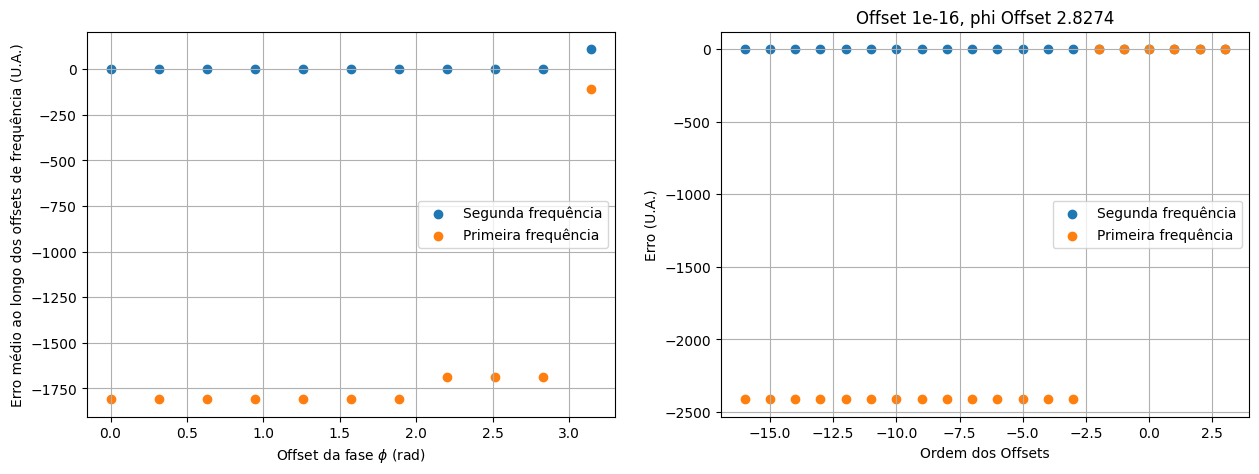

In [225]:
first_error, second_error = np.zeros((offsets.size, phi_offsets.size)), np.zeros((offsets.size, phi_offsets.size))
for j in range(phi_offsets.size):
    for k in range(offsets.size):
        compare_arr = np.sort(omegas_[k, j, args[k, j, :]][L_ - 2: L_])
        first_error[k, j] = compare_arr[0] - ws[1]
        second_error[k, j] = compare_arr[1] - (ws[1] + offsets[k])

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(phi_offsets, np.average(second_error, axis = 0), label = f"Segunda frequência")
plt.scatter(phi_offsets, np.average(first_error, axis = 0), label = "Primeira frequência")
plt.xlabel(r"Offset da fase $\phi$ (rad)")
plt.ylabel("Erro médio ao longo dos offsets de frequência (U.A.)")
# plt.ylim(-1810, -1808)
plt.legend()
plt.grid()

plt.subplot(122)
plt.scatter(np.log10(offsets), second_error[:, phi_i], label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error[:, phi_i], label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.title(f"Offset {offsets[i]}, phi Offset {round(phi_offsets[phi_i], 4)}")
# plt.ylim(-10*1e-12, 10*1e-12)
plt.legend()
plt.grid()


### Conclusão Preliminar

Ao contrário do $T_2$, a fase $\phi$ não parece mudar em nada o erro médio ao longo dos offsets de frequência. Porém, existe um caso especial, na fase de $\pi$, na qual o erro médio diminui significativamente, crescendo conforme o offset de frequência diminui, mas sem uma progressão monotonica.